In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/semeion-novelty/semeion.data
/kaggle/input/musknovelty/musk.data


In [18]:
import cupy as cp
import numpy as np
from scipy.linalg import sqrtm, svd
from scipy.optimize import minimize
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
# === Softmax ===
def softmax(W, X):
    logits = X @ W
    logits -= np.max(logits, axis=1, keepdims=True)
    exp_logits = np.exp(logits)
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    return probs 

# === Matrix square root ===
def real_sqrtm(M):
    M_np = cp.asnumpy(M)
    return cp.asarray(sqrtm(M_np + 1e-6 * np.eye(M_np.shape[0])).real)

# === Scatter matrices ===
def compute_scatter_matrices(X, y):
    n_features = X.shape[1]
    classes = cp.unique(y)
    overall_mean = X.mean(axis=0)
    Sb = cp.zeros((n_features, n_features))
    Sw = cp.zeros((n_features, n_features))
    for c in classes:
        X_c = X[y == c]
        mean_c = X_c.mean(axis=0)
        n_c = X_c.shape[0]
        Sb += n_c * cp.outer(mean_c - overall_mean, mean_c - overall_mean)
        Sw += (X_c - mean_c).T @ (X_c - mean_c)
    return Sb, Sw  

In [ ]:
# === S2FS with L1 Regularization ===
def S2FS(X, y, alpha, lambda_, beta, max_iter=150, tol=1e-4, print_interval=30):
    X = cp.asarray(X)
    y = cp.asarray(y)
    n_samples, n_features = X.shape
    n_classes = len(cp.unique(y))
    Y = cp.eye(n_classes)[y]

    Sb, Sw = compute_scatter_matrices(X, y)
    Sb_sqrt = real_sqrtm(Sb) 
    inv_Sb_sqrt = cp.asarray(np.linalg.pinv(cp.asnumpy(Sb_sqrt)))

    W = cp.random.randn(n_features, n_classes)
    M = cp.zeros_like(W)
    N = cp.zeros_like(W)
    O = W.copy()
    Lambda1 = cp.zeros_like(W)
    Lambda2 = cp.zeros_like(W)
    Lambda3 = cp.zeros_like(W)

    mu = 1.0
    rho = 1.1

    for t in range(max_iter):
        # Update W via GPI
        A = inv_Sb_sqrt @ (cp.eye(n_features) + (alpha / mu) * Sw) @ inv_Sb_sqrt
        B = inv_Sb_sqrt @ (M + N + O - (Lambda1 + Lambda2 + Lambda3) / mu)
        Q, _ = cp.linalg.qr(cp.random.randn(n_features, n_classes))
        for _ in range(10):
            A_np = cp.asnumpy(A)
            eigenvalues = np.linalg.eigvals(A_np)
            max_eig = np.max(np.abs(eigenvalues))
            tau = 1 / (2 * max_eig) if max_eig > 0 else 1.0
            T = 2 * (cp.eye(n_features) - tau * A) @ Q + B
            U, _, Vt = svd(cp.asnumpy(T), full_matrices=False)
            Q = cp.asarray(U @ Vt)
        W_new = Sb_sqrt @ Q  

        # M update (l2,0-norm, hard-thresholding)
        threshold = cp.sqrt(2 * lambda_ / mu)
        M_temp = W_new - Lambda1 / mu
        row_norms = cp.linalg.norm(M_temp, axis=1)
        M_new = cp.where(row_norms[:, None] > threshold, M_temp, 0)

        # N update (L1-norm, soft-thresholding)
        N_new = cp.sign(W_new - Lambda2 / mu) * cp.maximum(cp.abs(W_new - Lambda2 / mu) - beta / mu, 0)

        # O update
        def loss_and_grad(O_vec):
            O_mat = O_vec.reshape(n_features, n_classes)
            probs = softmax(O_mat, cp.asnumpy(X))
            loss = -np.sum(cp.asnumpy(Y) * np.log(probs + 1e-12)) / n_samples
            loss += (mu / 2) * np.linalg.norm(O_mat - cp.asnumpy(W_new - Lambda3 / mu))**2
            grad = cp.asnumpy(X).T @ (probs - cp.asnumpy(Y)) / n_samples + mu * (O_mat - cp.asnumpy(W_new - Lambda3 / mu))
            return loss, grad.ravel()

        res = minimize(loss_and_grad, cp.asnumpy(O).ravel(), method='L-BFGS-B', jac=True)
        O_new = cp.asarray(res.x.reshape(n_features, n_classes))

        # Check convergence
        if cp.linalg.norm(W_new - M_new) < tol and cp.linalg.norm(W_new - N_new) < tol and cp.linalg.norm(W_new - O_new) < tol:
            print(f"Converged at iteration {t}")
            break

        # Update Lagrange multipliers
        Lambda1 += mu * (W_new - M_new)
        Lambda2 += mu * (W_new - N_new)
        Lambda3 += mu * (W_new - O_new)
        mu *= rho
        W, M, N, O = W_new, M_new, N_new, O_new

        # Print number of selected features
        if (t + 1) % print_interval == 0:
            feature_scores = cp.linalg.norm(W, axis=1)
            selected = feature_scores > cp.sqrt(2 * lambda_ / mu)
            n_selected_features = cp.sum(selected)
            print(f"Iteration {t + 1}: Number of selected features = {n_selected_features}")

    return cp.asnumpy(W), mu

In [21]:
# Load the dataset
df = pd.read_csv('/kaggle/input/semeion-novelty/semeion.data', header=None, sep='\s+')
print("Dataset loaded successfully")
print(f"Dataset shape: {df.shape}")
print("First few rows:\n", df.head())
print("Column count:", df.shape[1])

# Extract features and labels
X = df.iloc[:, :256].values  # First 256 columns are features
y_one_hot = df.iloc[:, 256:].values  # Last 10 columns are one-hot encoded labels
y = np.argmax(y_one_hot, axis=1)  # Convert one-hot to single label (0-9)
print(f"Feature matrix shape: {X.shape}")
print(f"Label array shape: {y.shape}")

# Preprocess
y = LabelEncoder().fit_transform(y)
X = StandardScaler().fit_transform(X)
print(f"Encoded labels shape: {y.shape}")
print(f"Scaled feature matrix shape: {X.shape}")

Dataset loaded successfully
Dataset shape: (1593, 266)
First few rows:
    0    1    2    3    4    5    6    7    8    9    ...  256  257  258  259  \
0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  ...    1    0    0    0   
1  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  ...    1    0    0    0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...    1    0    0    0   
3  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  ...    1    0    0    0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...    1    0    0    0   

   260  261  262  263  264  265  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 266 columns]
Column count: 266
Feature matrix shape: (1593, 256)
Label array shape: (1593,)
Encoded labels shape: (1593,)
Scaled feature matrix shape: (1593, 256)


In [23]:
# Hyperparameter lists
alpha_list = [0.01,0.1,1,10]  
lambda_list = [0.0001, 0.001,0.01] 
beta_list = [0.0001, 0.001, 0.01] 

# K-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
best_acc = 0
best_params = None
best_W = None
best_mu = None
final_scores = None
sorted_indices = None

for alpha in alpha_list:
    for lambda_ in lambda_list:
        for beta in beta_list:
            print(f"Training with α={alpha}, λ={lambda_}, β={beta}")
            accuracies = []
            for train_idx, val_idx in kf.split(X):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                W, mu_final = S2FS(X_train, y_train, alpha, lambda_, beta, max_iter=150)
                feature_scores = np.linalg.norm(W, axis=1)
                selected = np.argsort(feature_scores)[::-1][:int(0.1 * X.shape[1])]
                clf = KNeighborsClassifier(n_neighbors=5)
                clf.fit(X_train[:, selected], y_train)
                acc = clf.score(X_val[:, selected], y_val)
                accuracies.append(acc)
            avg_acc = np.mean(accuracies)
            print(f"Average Validation Accuracy: {avg_acc:.4f}")
            if avg_acc > best_acc:
                best_acc = avg_acc
                best_params = (alpha, lambda_, beta)
                best_W = W
                best_mu = mu_final
                final_scores = np.linalg.norm(best_W, axis=1)
                sorted_indices = np.argsort(final_scores)[::-1]

Training with α=0.01, λ=0.0001, β=0.0001
Iteration 30: Number of selected features = 0
Iteration 60: Number of selected features = 129
Iteration 90: Number of selected features = 211
Iteration 120: Number of selected features = 256
Iteration 150: Number of selected features = 256
Iteration 30: Number of selected features = 0
Iteration 60: Number of selected features = 140
Iteration 90: Number of selected features = 216
Iteration 120: Number of selected features = 256
Iteration 150: Number of selected features = 256
Iteration 30: Number of selected features = 0
Iteration 60: Number of selected features = 126
Iteration 90: Number of selected features = 199
Iteration 120: Number of selected features = 256
Iteration 150: Number of selected features = 256
Average Validation Accuracy: 0.7050
Training with α=0.01, λ=0.0001, β=0.001
Iteration 30: Number of selected features = 0
Iteration 60: Number of selected features = 133
Iteration 90: Number of selected features = 254
Iteration 120: Number

In [24]:
# Final selected feature count
final_threshold = np.sqrt(2 * best_params[1] / best_mu)
selected_features = final_scores > final_threshold
n_selected = np.sum(selected_features)

print("\nBest Hyperparameters:")
print(f"Alpha = {best_params[0]}, Lambda = {best_params[1]}, Beta = {best_params[2]}")
print(f"Best Average Validation Accuracy: {best_acc:.4f}")
print(f"Number of Selected Features (||w_i|| > √(2λ/μ)): {n_selected}")


Best Hyperparameters:
Alpha = 0.01, Lambda = 0.01, Beta = 0.0001
Best Average Validation Accuracy: 0.7389
Number of Selected Features (||w_i|| > √(2λ/μ)): 255


Ratio: 0.02, Features: 5, Accuracy: 0.3421
Ratio: 0.04, Features: 10, Accuracy: 0.5712
Ratio: 0.06, Features: 15, Accuracy: 0.7150
Ratio: 0.08, Features: 20, Accuracy: 0.7878
Ratio: 0.10, Features: 25, Accuracy: 0.8148
Ratio: 0.12, Features: 30, Accuracy: 0.8286
Ratio: 0.14, Features: 35, Accuracy: 0.8669
Ratio: 0.16, Features: 40, Accuracy: 0.8788
Ratio: 0.18, Features: 46, Accuracy: 0.8876
Ratio: 0.20, Features: 51, Accuracy: 0.8939


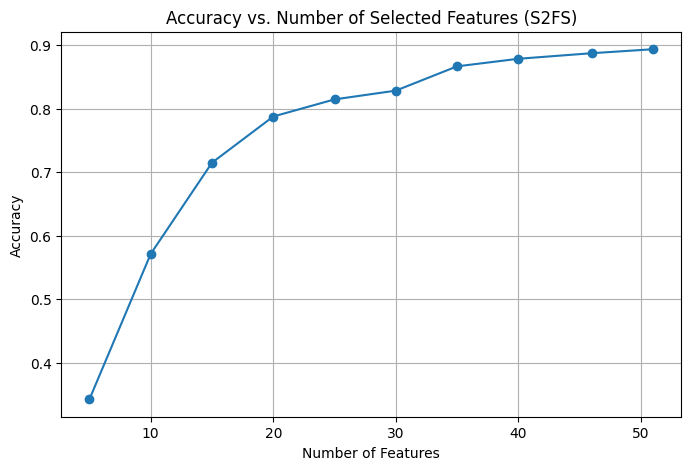

In [ ]:
# Accuracy vs. Feature Ratio Plot
ratios = np.linspace(0.02, 0.2, 10)
accuracies = []
feature_counts = []

for r in ratios:
    k = max(1, int(r * X.shape[1]))
    selected = sorted_indices[:k]
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X[:, selected], y) 
    acc = clf.score(X[:, selected], y) 
    accuracies.append(acc)
    feature_counts.append(k)
    print(f"Ratio: {r:.2f}, Features: {k}, Accuracy: {acc:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(feature_counts, accuracies, marker='o')
plt.title("Accuracy vs. Number of Selected Features (S2FS)")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()